### Exploration of false alarms, using Portland Fire & Rescue incidents from 2010-2016

The purpose of this notebook is to explore the trends, distrubiton, and make up of false calls as reported by the Portland Fire andn Rescue. The data explored is 7 years worth of incident data provided by Portland Fire and Rescue. Data dictionary here: https://github.com/hackoregon/emergency-response/wiki/Data-Dictionary

In notebook has:
* Connections and queries to fire data
* Overall trends of false calls and other derivitives
* Time plot trends of false call descriptions
* Spatial distribution of false calls by fire management areas and fireblocks

In [1]:
import geopandas as gpd
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import sys
import geopandas as gpd
%matplotlib inline

In [2]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

#### Establish connection and ability to query to Fire DB

In [3]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("database"), user=os.environ.get("user"), 
                            password = os.environ.get("password"), 
                            host=os.environ.get("host"), port=os.environ.get("port"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [4]:
#function to to query a table from postgres and create df.
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)
        
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()

In [5]:
#function to to query a table with geometry from postrgres and convert to df.
from geopandas import GeoSeries, GeoDataFrame

def gpd_query(QUERY):
    '''
    takes SQL query string, connects to postgres, and creates geopandas dataframe
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY+'\r\n')
        geo_df = GeoDataFrame.from_postgis(QUERY, 
        conn, geom_col='geom', crs={'init': u'epsg:4326'}, 
        coerce_float=False)
        
        print("created geopandas dataframe")
        return geo_df
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()

In [6]:
QUERY2='''SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC
'''

df2 = gpd_query(QUERY2)

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC


created geopandas dataframe


#### query tabular data
Join incidents table to incsitfound, incsitfoundsub, and typenaturecode


In [7]:
QUERY4='''SELECT incident.incident_id,incident.fmarespcomp, incident.fireblock, incident.incdate, incsitfoundclass.incsitfoundclass_id, incsitfoundclass.description as incDescription, typenaturecode.description as typeDescription
FROM incident
  INNER JOIN incsitfound
    ON incident.incsitfoundprm_id = incsitfound.incsitfound_id
  LEFT JOIN incsitfoundsub
    ON incsitfound.incsitfoundsub_id = incsitfoundsub.incsitfoundsub_id
  LEFT JOIN incsitfoundclass
    ON incsitfoundsub.incsitfoundclass_id = incsitfoundclass.incsitfoundclass_id
   LEFT JOIN typenaturecode
   ON incident.typenaturecode_id = typenaturecode.typenaturecode_id;
'''
df4 = pquery(QUERY4)

Opened database successfully
SQL QUERY = SELECT incident.incident_id,incident.fmarespcomp, incident.fireblock, incident.incdate, incsitfoundclass.incsitfoundclass_id, incsitfoundclass.description as incDescription, typenaturecode.description as typeDescription
FROM incident
  INNER JOIN incsitfound
    ON incident.incsitfoundprm_id = incsitfound.incsitfound_id
  LEFT JOIN incsitfoundsub
    ON incsitfound.incsitfoundsub_id = incsitfoundsub.incsitfoundsub_id
  LEFT JOIN incsitfoundclass
    ON incsitfoundsub.incsitfoundclass_id = incsitfoundclass.incsitfoundclass_id
   LEFT JOIN typenaturecode
   ON incident.typenaturecode_id = typenaturecode.typenaturecode_id;



In [8]:
#QUERY5='''SELECT incident.incident_id,incident.fmarespcomp, incident.fireblock, incident.incdate
#FROM incident
#  LEFT JOIN responder  
#    ON incident.incident_id = responder.incident_id;
#'''
#df4 = pquery(QUERY5)

In [9]:
#Convert date column to actual date. Calc a year and month column from the date column. 
df4['incdate'] = pd.to_datetime(df4['incdate'])
df4['year'] = pd.DatetimeIndex(df4['incdate']).year
df4['month'] = pd.DatetimeIndex(df4['incdate']).month
df4['month_year'] = df4['incdate'].apply(lambda x: x.strftime('%B-%Y'))  
#pd.DataFrame(df4, columns=['incdate'], dtype=datetime64)
incidents_df = df4
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512281 entries, 0 to 512280
Data columns (total 10 columns):
incident_id            512281 non-null int64
fmarespcomp            507765 non-null object
fireblock              512186 non-null object
incdate                512281 non-null datetime64[ns]
incsitfoundclass_id    512281 non-null int64
incdescription         512281 non-null object
typedescription        512278 non-null object
year                   512281 non-null int32
month                  512281 non-null int32
month_year             512281 non-null object
dtypes: datetime64[ns](1), int32(2), int64(2), object(5)
memory usage: 35.2+ MB


In [10]:
#False calls make up around 7% of the total calls from 2010-2016
df4.groupby('incdescription')['incdescription'].count().sort_values(ascending = 0)

incdescription
MEDICAL AID / RESCUE CALLS                    368084
SERVICE CALL                                   50997
FALSE CALLS                                    39210
GOOD INTENT CALLS                              24884
FIRE/EXPLOSION                                 16232
HAZARDOUS CONDITIONS                           10564
OTHER SITUATION FOUND                           1478
OVER PRESSURE RUPTURE, EXPLOSION, OVERHEAT       394
MUTUAL AID RESPONSE                              253
NATURAL CONDITIONS                               185
Name: incdescription, dtype: int64

In [12]:
#Create new dataframe with only false calls
falsecalls_df = df4[df4['incsitfoundclass_id'] == 7]

#39,210 false alarm records (out of 512,281 total)
falsecalls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39210 entries, 13 to 512279
Data columns (total 10 columns):
incident_id            39210 non-null int64
fmarespcomp            39004 non-null object
fireblock              39204 non-null object
incdate                39210 non-null datetime64[ns]
incsitfoundclass_id    39210 non-null int64
incdescription         39210 non-null object
typedescription        39210 non-null object
year                   39210 non-null int32
month                  39210 non-null int32
month_year             39210 non-null object
dtypes: datetime64[ns](1), int32(2), int64(2), object(5)
memory usage: 3.0+ MB


In [13]:
falsecalls_df.head()

,incident_id,fmarespcomp,fireblock,incdate,incsitfoundclass_id,incdescription,typedescription,year,month,month_year
13,828828,12,1248,2011-02-07,7,FALSE CALLS,AUTOMATIC FIRE ALARM-RES,2011,2,February-2011
17,835698,24,2403,2011-03-15,7,FALSE CALLS,AUTOMATIC FIRE ALARM-COMM,2011,3,March-2011
26,868367,09,0945,2011-08-22,7,FALSE CALLS,AUTOMATIC FIRE ALARM-RES,2011,8,August-2011
39,891549,30,3018,2011-12-15,7,FALSE CALLS,UNKNOWN/FIRE ONLY,2011,12,December-2011
51,897083,13,1318,2012-01-13,7,FALSE CALLS,AUTOMATIC FIRE ALARM-COMM,2012,1,January-2012


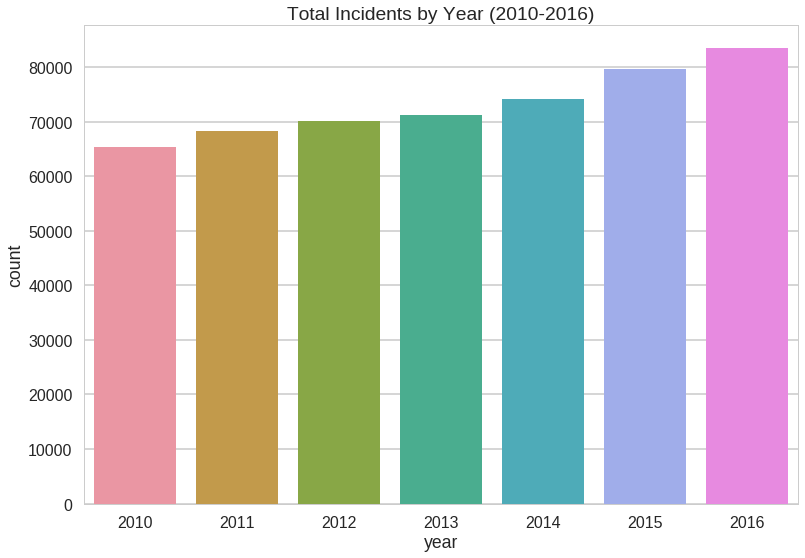

In [14]:
#total incidents over time
sns.set_style("whitegrid")
sns.set_palette('dark')
sns.set_context("poster")
sns.countplot(x='year', data = df4)
sns.plt.title('Total Incidents by Year (2010-2016)')

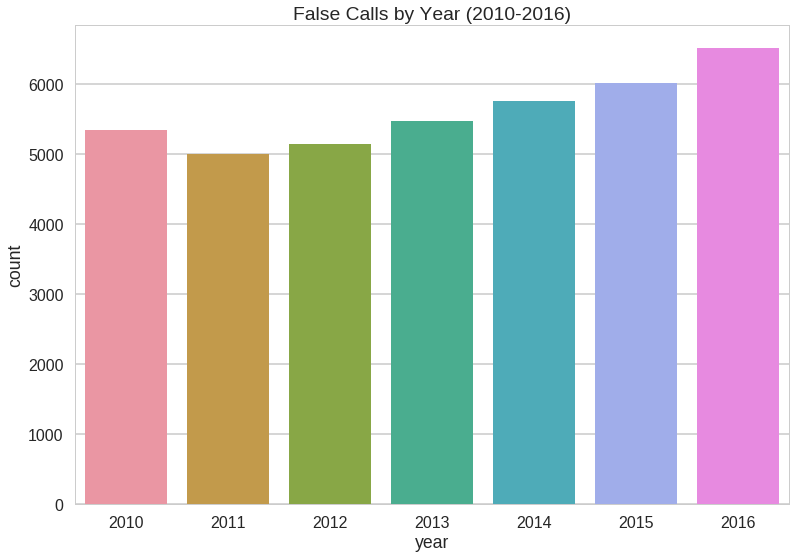

In [15]:
#False calls are rising over time. Almost in lockstep with total incidents over time (except for 2010)
sns.countplot(x='year', data = falsecalls_df)
sns.plt.title('False Calls by Year (2010-2016)')

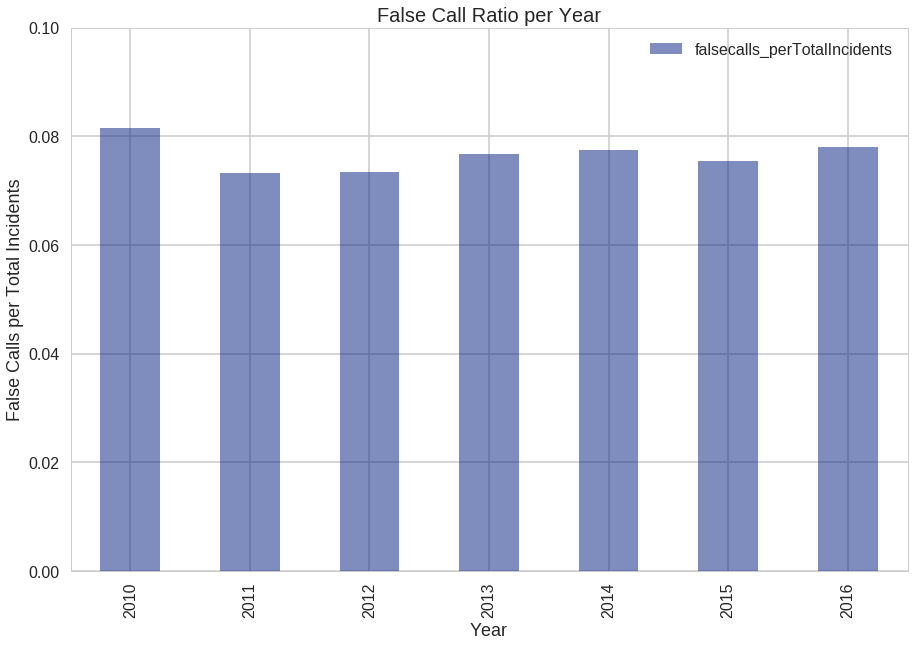

In [16]:
#Count incidents per year. Count faslse alarms per year. Join in to same data frame.  
fc_groupYear = (falsecalls_df.groupby(falsecalls_df.year)['incident_id'].count()).to_frame().reset_index()
fd_groupYear = (df4.groupby(df4.year)['incident_id'].count()).to_frame().reset_index()
fcfd_merge = pd.merge(left=fc_groupYear,right=fd_groupYear,  how='left', left_on='year', right_on='year')
fcfd_merge["falsecalls_perTotalIncidents"] = fcfd_merge["incident_id_x"] / fcfd_merge["incident_id_y"]

#plot
ax = fcfd_merge.plot(x='year', y='falsecalls_perTotalIncidents',ylim=(0,.1), kind='bar',figsize=(15, 10), alpha =.5)
ax.set_title('False Call Ratio per Year',fontsize= 20)
ax.set_xlabel("Year", fontsize=18)
ax.set_ylabel('False Calls per Total Incidents', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

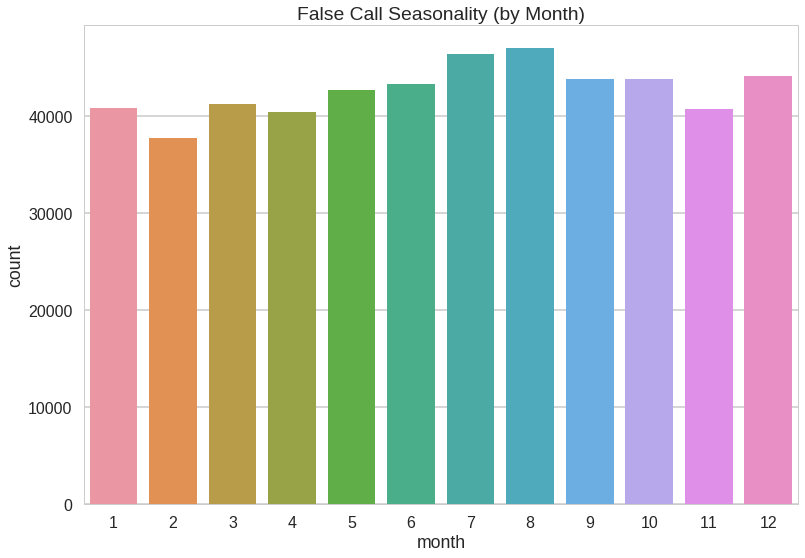

In [17]:
sns.set_style("whitegrid")
sns.set_palette('dark')
sns.set_context("poster")
#plt.figure(figsize=(10, 10))
#sns.countplot(x='incdate', data = df4, palette="Set3")
sns.countplot(x='month', data = df4)
sns.plt.title('False Call Seasonality (by Month)')


In [24]:
#### Type make up of False calls 

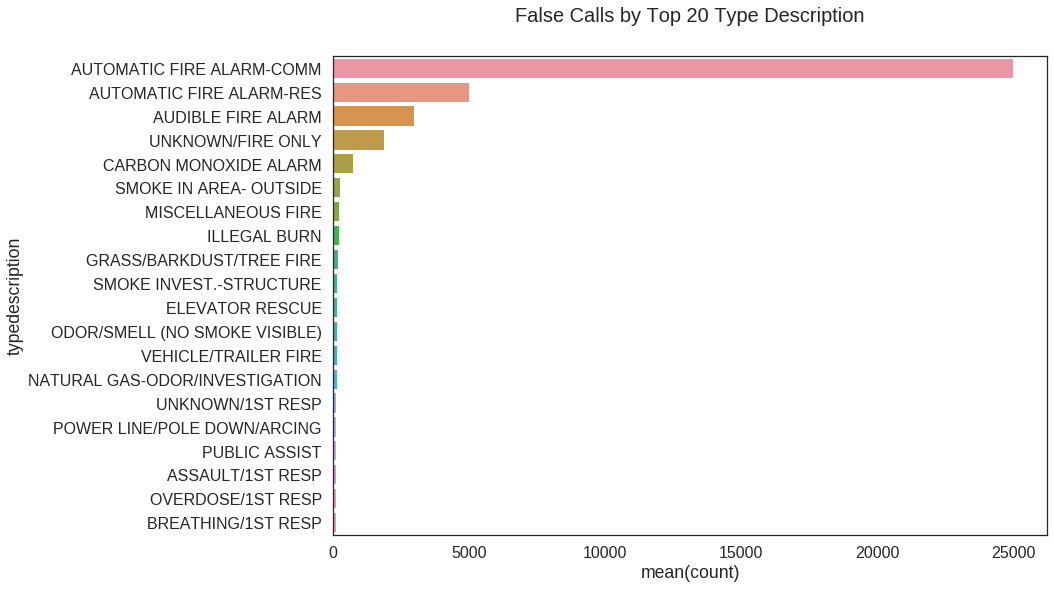

In [18]:
#Top type descriptions for false calls. 
sf3= falsecalls_df.groupby('typedescription')['typedescription'].count().sort_values(ascending = 0)
falsecalls_total = sf3.to_frame(name='count')
falsecalls_total.index.rename(name='typedescription')
falsecalls_total.reset_index( inplace=True)

#plot
sns.set_style("white") 
brplot =  sns.barplot(x="count", y="typedescription", data=falsecalls_total[:20])
title = ('False Calls by Top 20 Type Description')
brplot.set_title(title, fontsize=20, y=1.06)

#Vast majority are related to automatic fire alarms 30008 out of 39210 (ie 76.6%)

In [19]:
#Crosstabulate on typedescription to set up for timeseries plot. 
crosstab = pd.crosstab(falsecalls_df.incdate, falsecalls_df.typedescription)
select_df = crosstab[['AUTOMATIC FIRE ALARM-COMM', 'AUTOMATIC FIRE ALARM-RES', 'AUDIBLE FIRE ALARM', 
                      'UNKNOWN/FIRE ONLY', 'CARBON MONOXIDE ALARM', 'SMOKE IN AREA- OUTSIDE']]

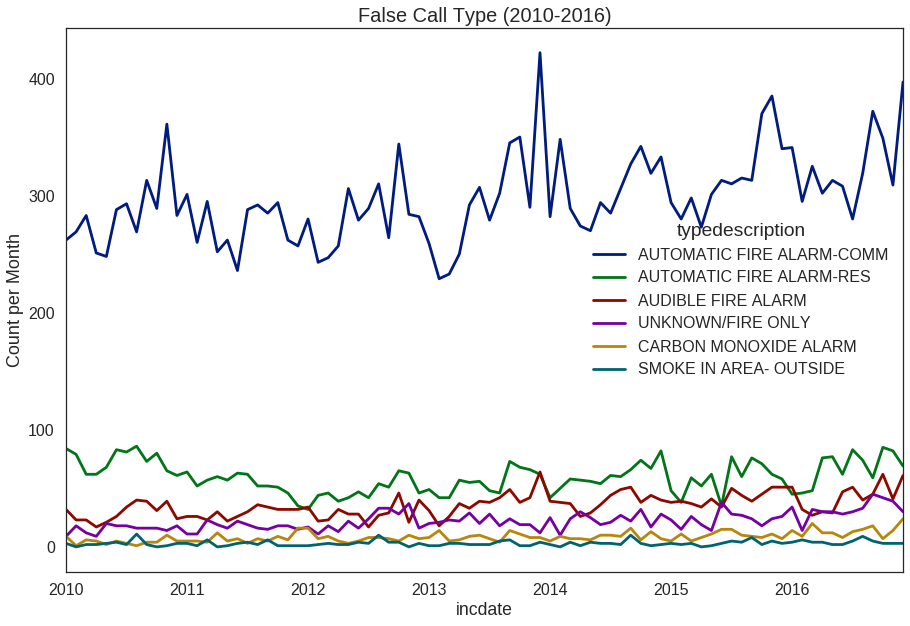

In [20]:
select_df_yearly = select_df.resample('M').sum()
#select_df.head()
ax1 = select_df_yearly.ix['01-2010':'12-2016'].plot(figsize=(15, 10))
ax1.set_title('False Call Type (2010-2016)',fontsize= 20)
ax1.set_ylabel('Count per Month', fontsize=18)
sns.set_style("whitegrid", {'axes.grid' : False})
#select_df.info()

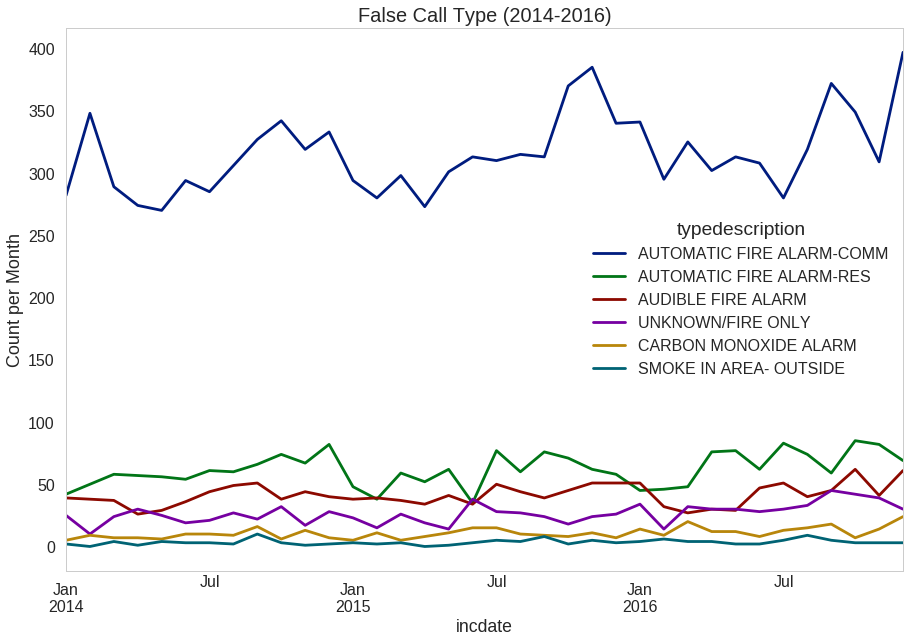

In [21]:
#df39 = falsecalls_byday_df.loc['20130102','20130104','','']

select_df_monthly = select_df.resample('M').sum()
ax2 = select_df_monthly.ix['01-2014':'12-2016'].plot(figsize=(15, 10))
ax2.set_title('False Call Type (2014-2016)',fontsize= 20)
ax2.set_ylabel('Count per Month', fontsize=18)

### Geographic exploration (by Fire Managmenet Area and Fire Block)

Query geometry from pg instance. 

In [22]:
QUERY3='''SELECT gid, fma, resp_zone, geom
FROM fblocks;
'''

df3 = gpd_query(QUERY3)
df3 = df3.rename(columns = {'resp_zone':'fireblock'})
df3.head(5)

Opened database successfully
SQL QUERY = SELECT gid, fma, resp_zone, geom
FROM fblocks;


created geopandas dataframe


,gid,fma,fireblock,geom
0,1,01,0103,(POLYGON ((-122.6739595339999 45.5319685220000...
1,2,01,0106,"(POLYGON ((-122.669984655 45.52957948400007, -..."
2,3,01,0109,"(POLYGON ((-122.669181766 45.52755928500005, -..."
3,4,01,0111,"(POLYGON ((-122.666151838 45.52710833500004, -..."
4,5,01,0112,"(POLYGON ((-122.664736116 45.52866324200005, -..."


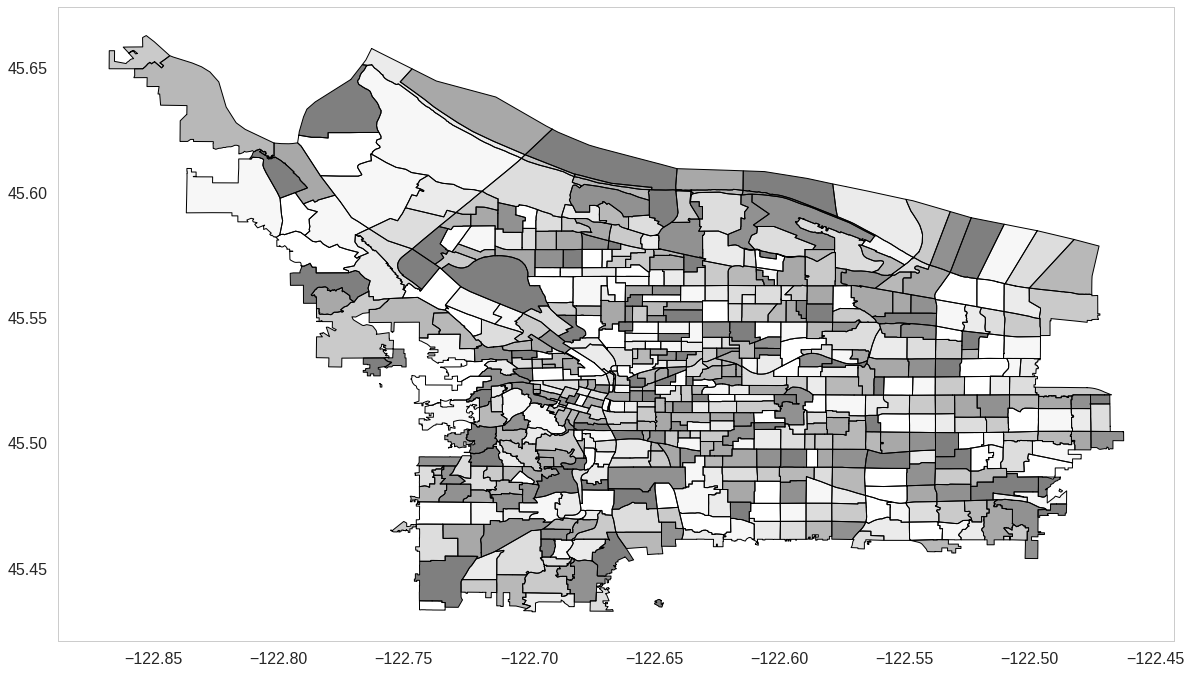

In [23]:
#Fireblocks
#df3.plot(figsize=(20,20), column='fma') 
df3.plot(figsize=(20,20))

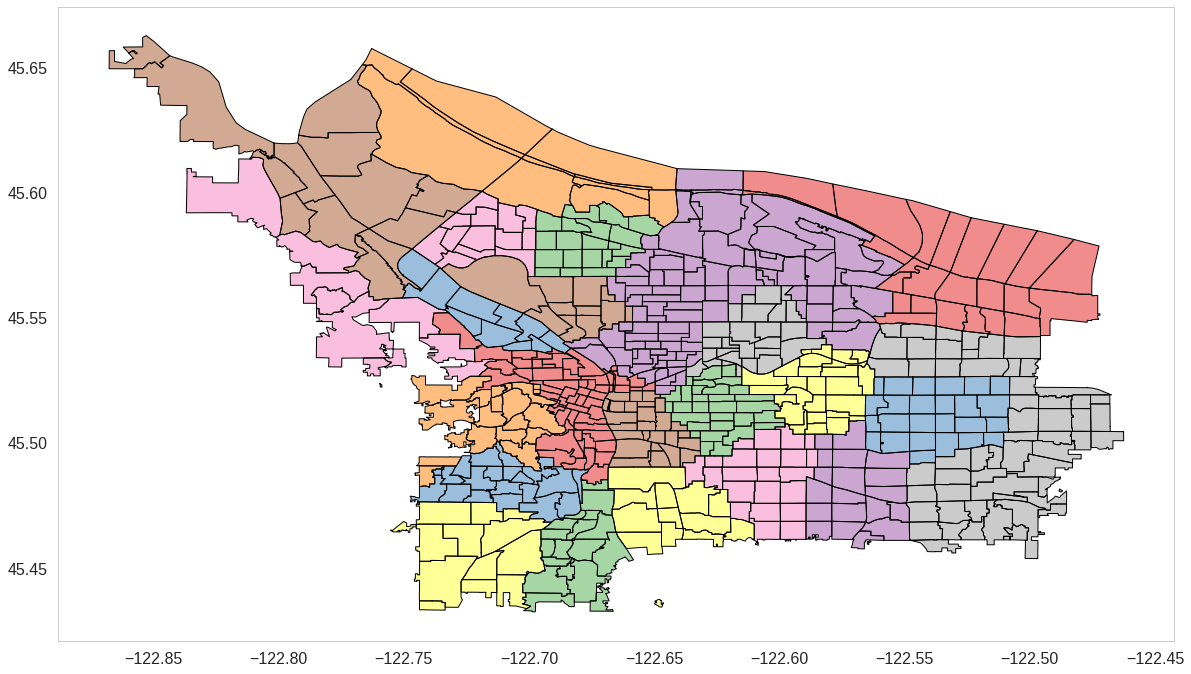

In [25]:
#Plot fire blocks and FMA's. FMA's correspond to the colors, Fireblocks to the individual geometries.
#Fireblocks are coincidental with FMA's. 
df3.plot(figsize=(20,20), column='fma')

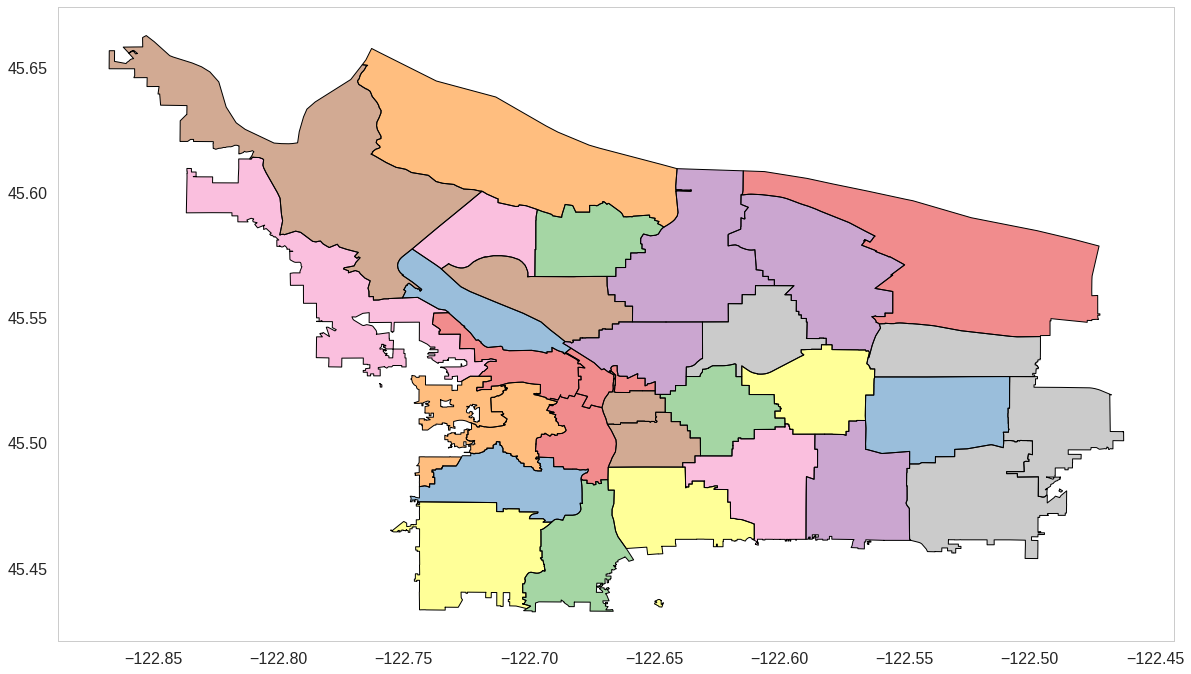

In [26]:
FMAs = df3.dissolve(by='fma').reset_index()
FMAs.plot(figsize=(20,20), column='fma') 

In [28]:
FMAs.head() 

,fma,geom,gid,fireblock
0,01,"POLYGON ((-122.654647701 45.52077605700003, -1...",1,0103
1,02,"POLYGON ((-122.55780558 45.55178617400003, -12...",17,0201
2,03,"POLYGON ((-122.687297627 45.51911160700007, -1...",41,0315
3,04,"POLYGON ((-122.667871984 45.49139775000003, -1...",68,0427
4,05,"POLYGON ((-122.744500398 45.47635703600008, -1...",85,0512


#### join incident counts and other fields in interest to FMAs and Fire blocks

In [29]:
falsecalls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39210 entries, 13 to 512279
Data columns (total 10 columns):
incident_id            39210 non-null int64
fmarespcomp            39004 non-null object
fireblock              39204 non-null object
incdate                39210 non-null datetime64[ns]
incsitfoundclass_id    39210 non-null int64
incdescription         39210 non-null object
typedescription        39210 non-null object
year                   39210 non-null int32
month                  39210 non-null int32
month_year             39210 non-null object
dtypes: datetime64[ns](1), int32(2), int64(2), object(5)
memory usage: 3.0+ MB


##### fireblock data prep

In [30]:
#Sum count all incidents by blockgroup
TotalIncident_groupFireblock = (incidents_df.groupby(incidents_df.fireblock)['incident_id'].count()).to_frame().reset_index()
TotalIncident_groupFireblock.columns = ['fireblock', 'TotalIncident_Count']

#Sum count of false calls by block group
sf1 = falsecalls_df.groupby(['fireblock'])['incsitfoundclass_id'].count()
df5 = sf1.to_frame().reset_index()
df5.columns = ['fireblock', 'FalseCall_Count']




In [32]:
crosstab = pd.crosstab(falsecalls_df.fireblock, falsecalls_df.typedescription)
FA_Desc_fireblock_df = crosstab[['AUTOMATIC FIRE ALARM-COMM', 'AUTOMATIC FIRE ALARM-RES', 'AUDIBLE FIRE ALARM', 
                      'UNKNOWN/FIRE ONLY', 'CARBON MONOXIDE ALARM', 'SMOKE IN AREA- OUTSIDE']]

FA_Desc_fireblock_df.index.rename(name='fireblock')
FA_Desc_fireblock_df.reset_index( inplace=True)
FA_Desc_fireblock_df.head()

typedescription,fireblock,AUTOMATIC FIRE ALARM-COMM,AUTOMATIC FIRE ALARM-RES,AUDIBLE FIRE ALARM,UNKNOWN/FIRE ONLY,CARBON MONOXIDE ALARM,SMOKE IN AREA- OUTSIDE
0,0103,224,3,27,0,1,0
1,0106,1,0,0,0,0,1
2,0109,339,2,25,1,0,1
3,0111,0,0,0,0,0,0
4,0112,50,0,4,0,1,0


In [33]:
df3.reset_index()
df5.reset_index()
FA_Desc_fireblock_df.reset_index()

#join the false call totals by fireblock to the fireblock geometry
df7 = pd.merge(left=df3,right=df5,  how='left', left_on='fireblock', right_on='fireblock', suffixes=('_left', '_right'))
#join the crosstabulated call descriptions to geometry
Fireblock_Summaries_df = pd.merge(left=df7,right=FA_Desc_fireblock_df,  how='left', left_on='fireblock', right_on='fireblock', suffixes=('_left', '_right'))
#Join in total incidents by fireblock
Fireblock_Summaries_df = pd.merge(left=Fireblock_Summaries_df,right=TotalIncident_groupFireblock,  how='left', left_on='fireblock', right_on='fireblock', suffixes=('_left', '_right'))

#Fill NaN's with 0's
Fireblock_Summaries_df.update(Fireblock_Summaries_df[['FalseCall_Count', 'TotalIncident_Count', 'AUTOMATIC FIRE ALARM-RES', 'AUTOMATIC FIRE ALARM-COMM']].fillna(0))

#calculate ratio of commercial and resident fire alarms
Fireblock_Summaries_df["alarmcomm_fa_ratio"] = (Fireblock_Summaries_df["AUTOMATIC FIRE ALARM-COMM"]/Fireblock_Summaries_df["TotalIncident_Count"]).fillna(0)
Fireblock_Summaries_df["alarmres_fa_ratio"] = (Fireblock_Summaries_df["AUTOMATIC FIRE ALARM-RES"]/Fireblock_Summaries_df["TotalIncident_Count"]).fillna(0)
Fireblock_Summaries_df["fa_total_ratio"] = (Fireblock_Summaries_df['FalseCall_Count']/Fireblock_Summaries_df["TotalIncident_Count"]).fillna(0)
Fireblock_Summaries_df.head()

,gid,fma,fireblock,geom,FalseCall_Count,AUTOMATIC FIRE ALARM-COMM,AUTOMATIC FIRE ALARM-RES,AUDIBLE FIRE ALARM,UNKNOWN/FIRE ONLY,CARBON MONOXIDE ALARM,SMOKE IN AREA- OUTSIDE,TotalIncident_Count,alarmcomm_fa_ratio,alarmres_fa_ratio,fa_total_ratio
0,1,01,0103,(POLYGON ((-122.6739595339999 45.5319685220000...,272.0,224.0,3.0,27.0,0.0,1.0,0.0,5834.0,0.038396,0.000514,0.046623
1,2,01,0106,"(POLYGON ((-122.669984655 45.52957948400007, -...",5.0,1.0,0.0,0.0,0.0,0.0,1.0,702.0,0.001425,0.000000,0.007123
2,3,01,0109,"(POLYGON ((-122.669181766 45.52755928500005, -...",404.0,339.0,2.0,25.0,1.0,0.0,1.0,8497.0,0.039896,0.000235,0.047546
3,4,01,0111,"(POLYGON ((-122.666151838 45.52710833500004, -...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.000000,0.000000,0.100000
4,5,01,0112,"(POLYGON ((-122.664736116 45.52866324200005, -...",63.0,50.0,0.0,4.0,0.0,1.0,0.0,1050.0,0.047619,0.000000,0.060000


##### FMA data prep

In [34]:
#Sum count all incidents by FMA
TotalIncident_groupFMA = (incidents_df.groupby(incidents_df.fmarespcomp)['incident_id'].count()).to_frame().reset_index()
TotalIncident_groupFMA.columns = ['fmarespcomp', 'TotalIncident_Count']

#Sum count of false calls by FMA
sf_fma = falsecalls_df.groupby(['fmarespcomp'])['incsitfoundclass_id'].count()
df8 = sf_fma.to_frame().reset_index()
df8.columns = ['fmarespcomp', 'FalseCall_Count']

In [35]:
crosstab2 = pd.crosstab(falsecalls_df.fmarespcomp, falsecalls_df.typedescription)
FA_Desc_fma_df = crosstab2[['AUTOMATIC FIRE ALARM-COMM', 'AUTOMATIC FIRE ALARM-RES', 'AUDIBLE FIRE ALARM', 
                      'UNKNOWN/FIRE ONLY', 'CARBON MONOXIDE ALARM', 'SMOKE IN AREA- OUTSIDE']]
FA_Desc_fma_df.index.rename(name='fmarespcomp')
FA_Desc_fma_df.reset_index( inplace=True)
FA_Desc_fma_df.head()


typedescription,fmarespcomp,AUTOMATIC FIRE ALARM-COMM,AUTOMATIC FIRE ALARM-RES,AUDIBLE FIRE ALARM,UNKNOWN/FIRE ONLY,CARBON MONOXIDE ALARM,SMOKE IN AREA- OUTSIDE
0,0,0,0,0,0,0,0
1,01,2440,9,144,18,4,3
2,02,754,112,44,51,13,9
3,03,2909,235,350,72,32,16
4,04,2920,46,266,55,24,8


In [36]:
FMAs.reset_index()
df8.reset_index()
FA_Desc_fma_df.reset_index()

#join the false call totals to the FMA geometry
df9 = pd.merge(left=FMAs,right=df8,  how='left', left_on='fma', right_on='fmarespcomp', suffixes=('_left', '_right'))
#join the crosstabulated call descriptions to geometry
FMA_Summaries_df = pd.merge(left=df9,right=FA_Desc_fma_df,  how='left', left_on='fmarespcomp', right_on='fmarespcomp', suffixes=('_left', '_right'))
FMA_Summaries_df.head()
#Join in total incidents by fFMA
FMA_Summaries_df = pd.merge(left=FMA_Summaries_df,right=TotalIncident_groupFMA,  how='left', left_on='fma', right_on='fmarespcomp', suffixes=('_left', '_right'))

#Fill NaN's with 0's
FMA_Summaries_df.update(FMA_Summaries_df[['FalseCall_Count', 'TotalIncident_Count', 'AUTOMATIC FIRE ALARM-RES', 'AUTOMATIC FIRE ALARM-COMM']].fillna(0))

#calculate ratio of commercial and resident fire alarms. Fill NaN's with 0. 
FMA_Summaries_df["alarmcomm_fa_ratio"] = (FMA_Summaries_df["AUTOMATIC FIRE ALARM-COMM"]/FMA_Summaries_df["TotalIncident_Count"]).fillna(0)
FMA_Summaries_df["alarmres_fa_ratio"] = (FMA_Summaries_df["AUTOMATIC FIRE ALARM-RES"]/FMA_Summaries_df["TotalIncident_Count"]).fillna(0)
FMA_Summaries_df["fa_total_ratio"] = (FMA_Summaries_df['FalseCall_Count']/FMA_Summaries_df["TotalIncident_Count"]).fillna(0)

FMA_Summaries_df.head()

,fma,geom,gid,fireblock,fmarespcomp_left,FalseCall_Count,AUTOMATIC FIRE ALARM-COMM,AUTOMATIC FIRE ALARM-RES,AUDIBLE FIRE ALARM,UNKNOWN/FIRE ONLY,CARBON MONOXIDE ALARM,SMOKE IN AREA- OUTSIDE,fmarespcomp_right,TotalIncident_Count,alarmcomm_fa_ratio,alarmres_fa_ratio,fa_total_ratio
0,01,"POLYGON ((-122.654647701 45.52077605700003, -1...",1,0103,01,2824,2440,9,144,18,4,3,01,42746,0.057081,0.000211,0.066065
1,02,"POLYGON ((-122.55780558 45.55178617400003, -12...",17,0201,02,1060,754,112,44,51,13,9,02,12480,0.060417,0.008974,0.084936
2,03,"POLYGON ((-122.687297627 45.51911160700007, -1...",41,0315,03,3866,2909,235,350,72,32,16,03,30516,0.095327,0.007701,0.126688
3,04,"POLYGON ((-122.667871984 45.49139775000003, -1...",68,0427,04,3461,2920,46,266,55,24,8,04,29291,0.099689,0.001570,0.118159
4,05,"POLYGON ((-122.744500398 45.47635703600008, -1...",85,0512,05,643,231,232,73,42,29,5,05,7785,0.029672,0.029801,0.082595


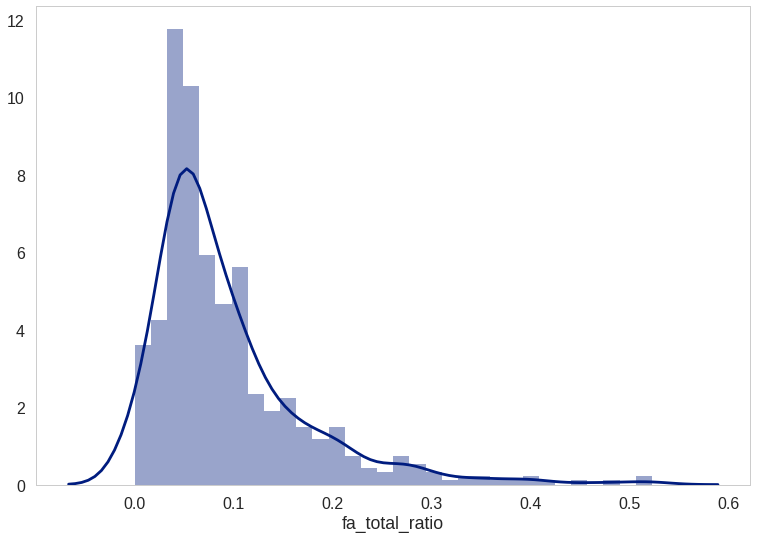

In [37]:
sns.distplot(Fireblock_Summaries_df["fa_total_ratio"])

### Spatial

### Total False Calls (over 7 year period) by Fire Management Area

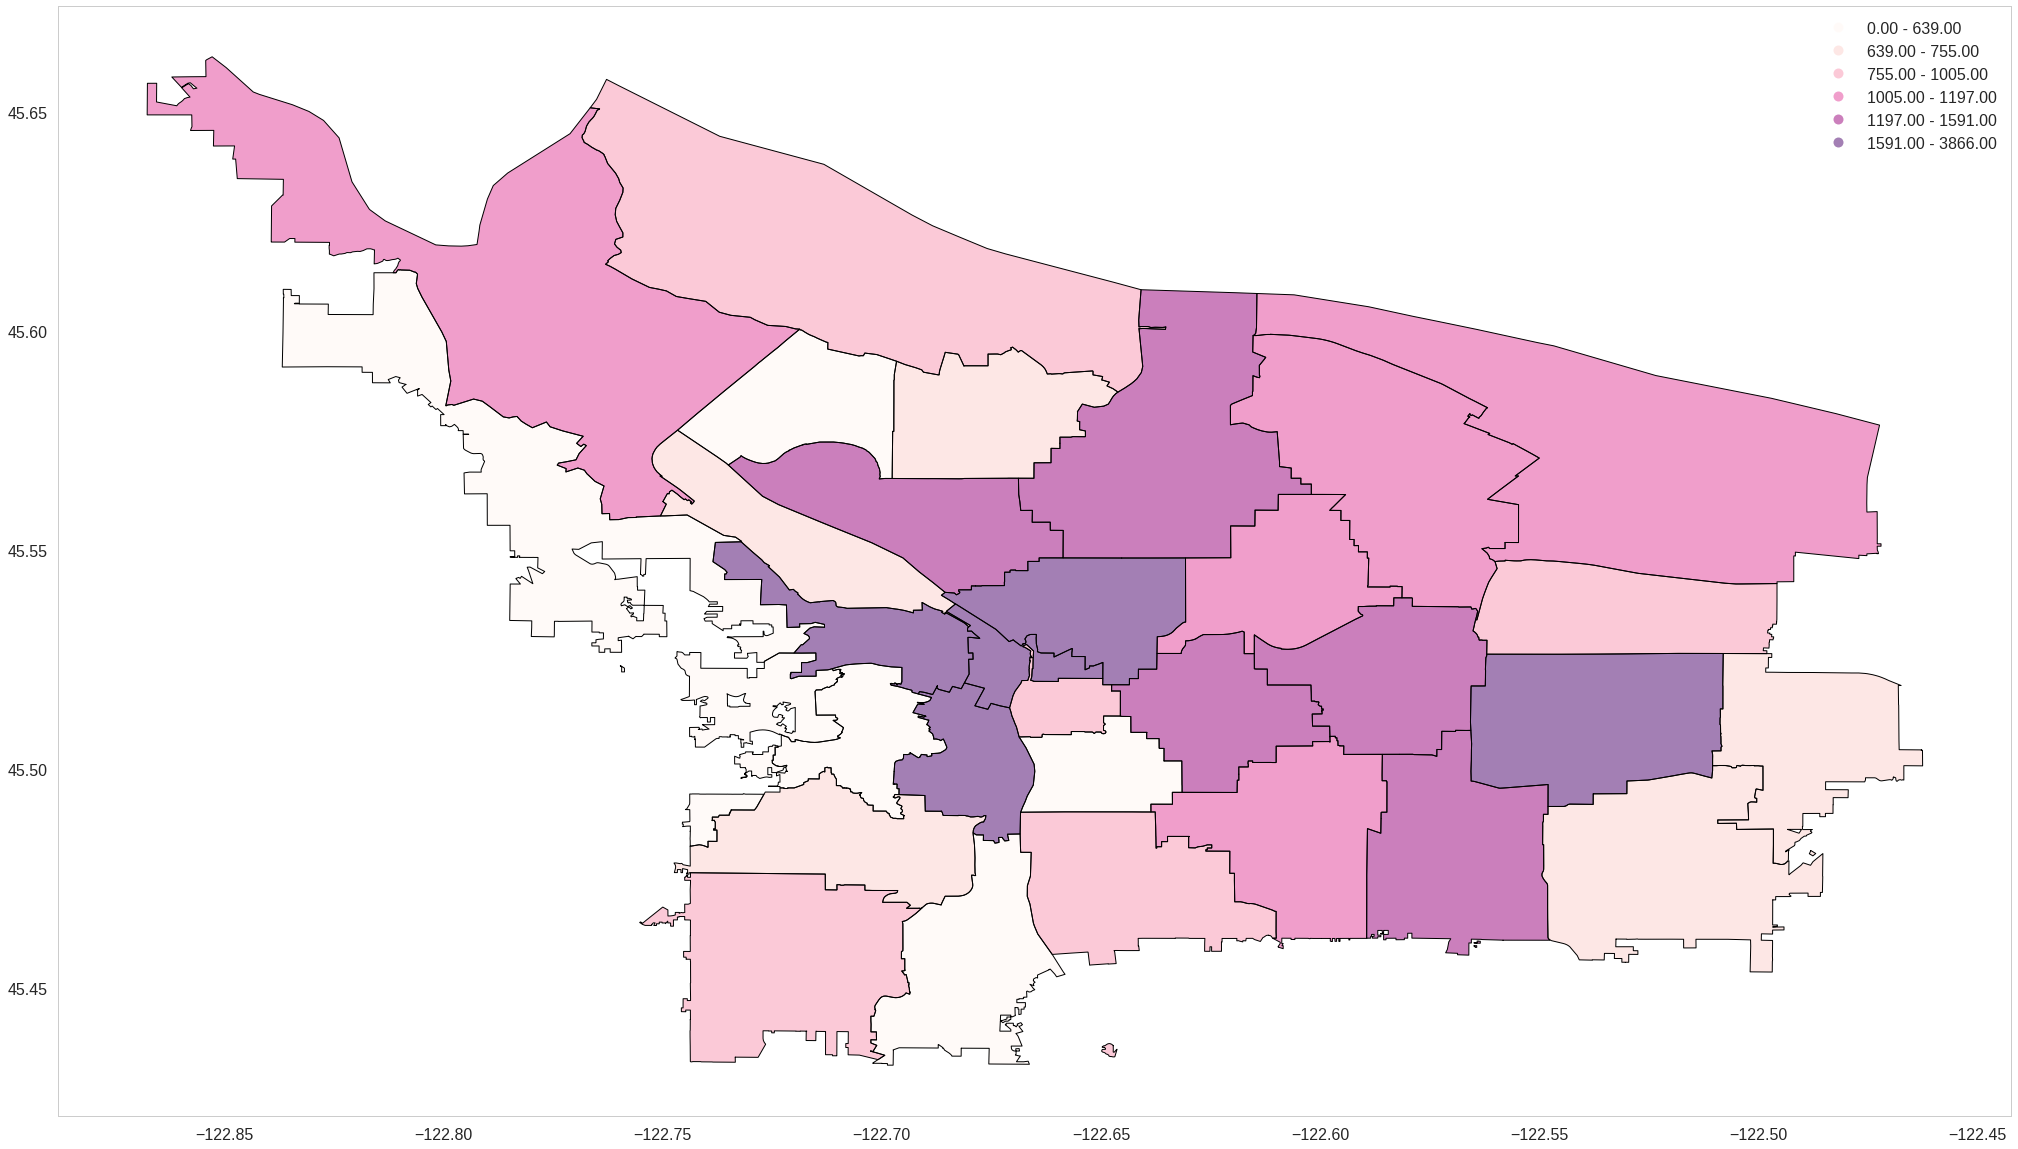

In [38]:
FMA_Summaries_df.plot(figsize=(35,35), column='FalseCall_Count', cmap='RdPu', scheme='QUANTILES', k=6, legend=True)

### Total False Calls (over 7 year period) by Fireblock

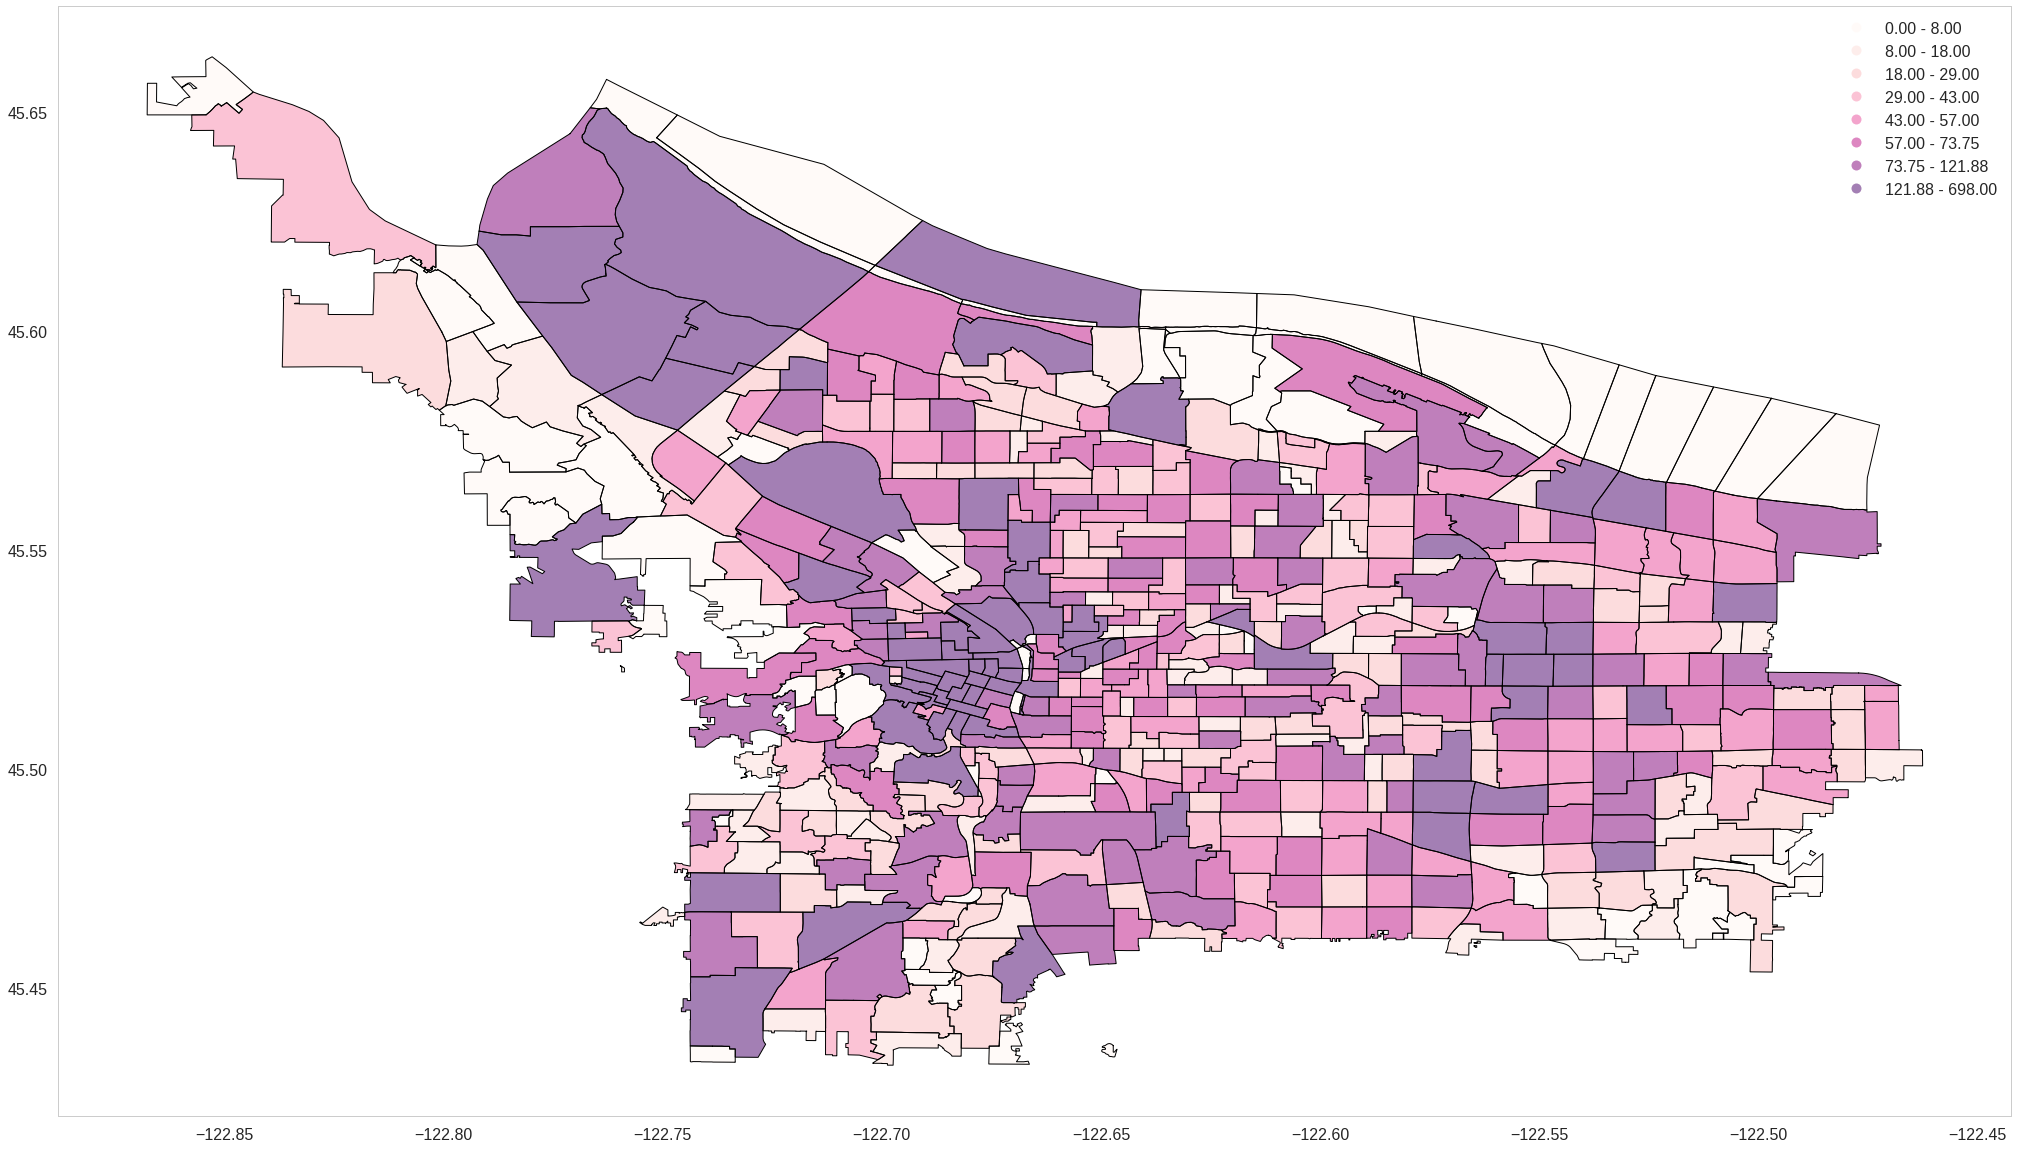

In [39]:
Fireblock_Summaries_df.plot(figsize=(35,35), column='FalseCall_Count', cmap='RdPu', scheme='QUANTILES', k=8, legend=True)

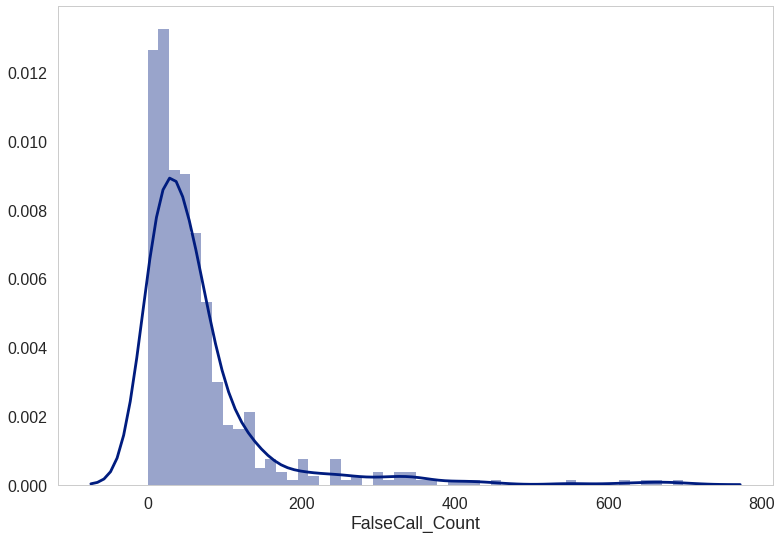

In [40]:
sns.distplot(Fireblock_Summaries_df["FalseCall_Count"])

### False Call to Total Incident Ratio by Fire Management Area

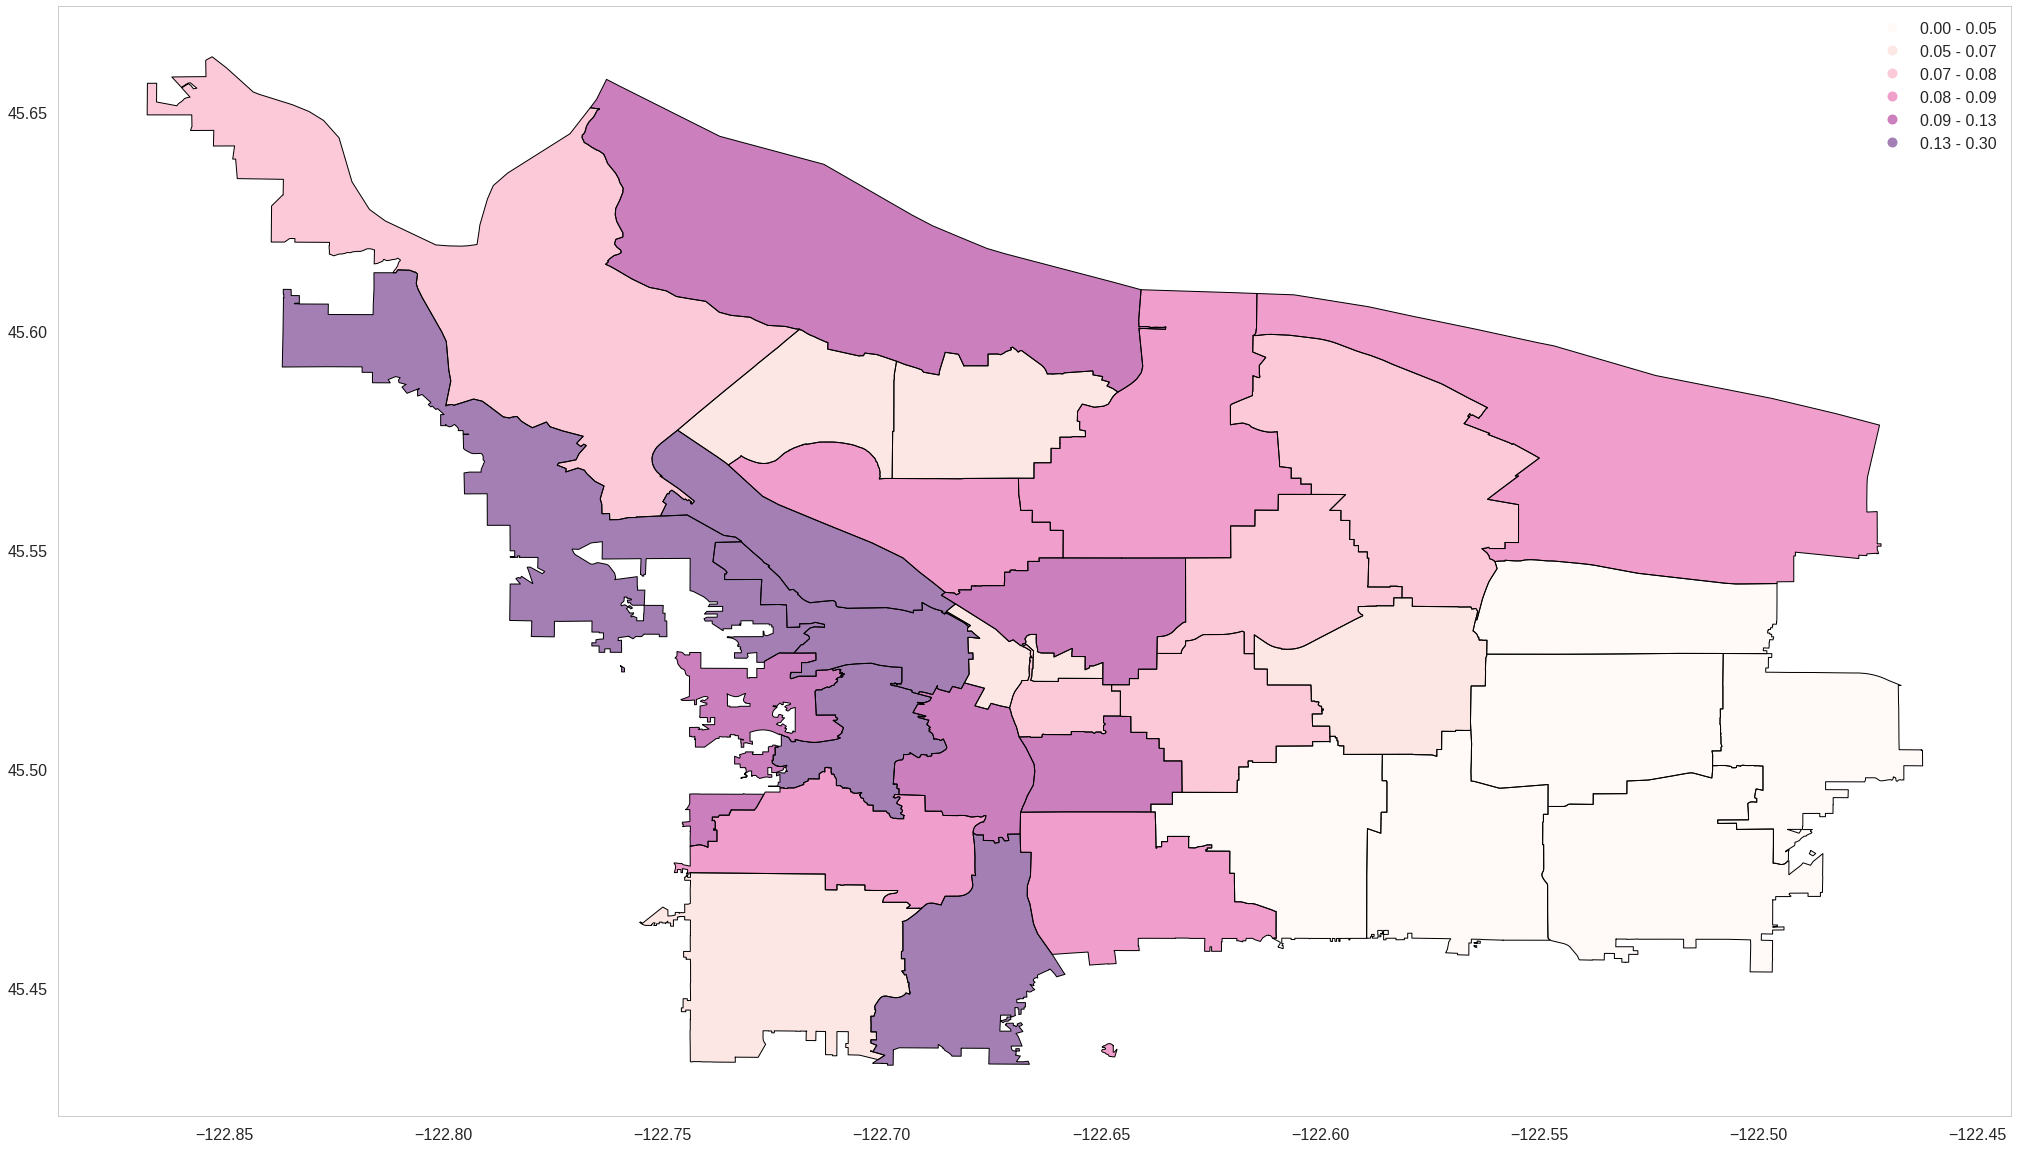

In [41]:
FMA_Summaries_df.plot(figsize=(35,35), column='fa_total_ratio', cmap='RdPu', scheme='QUANTILES', k=6, legend=True)

### False Call to Total Incident Ratio by Fire Management Area

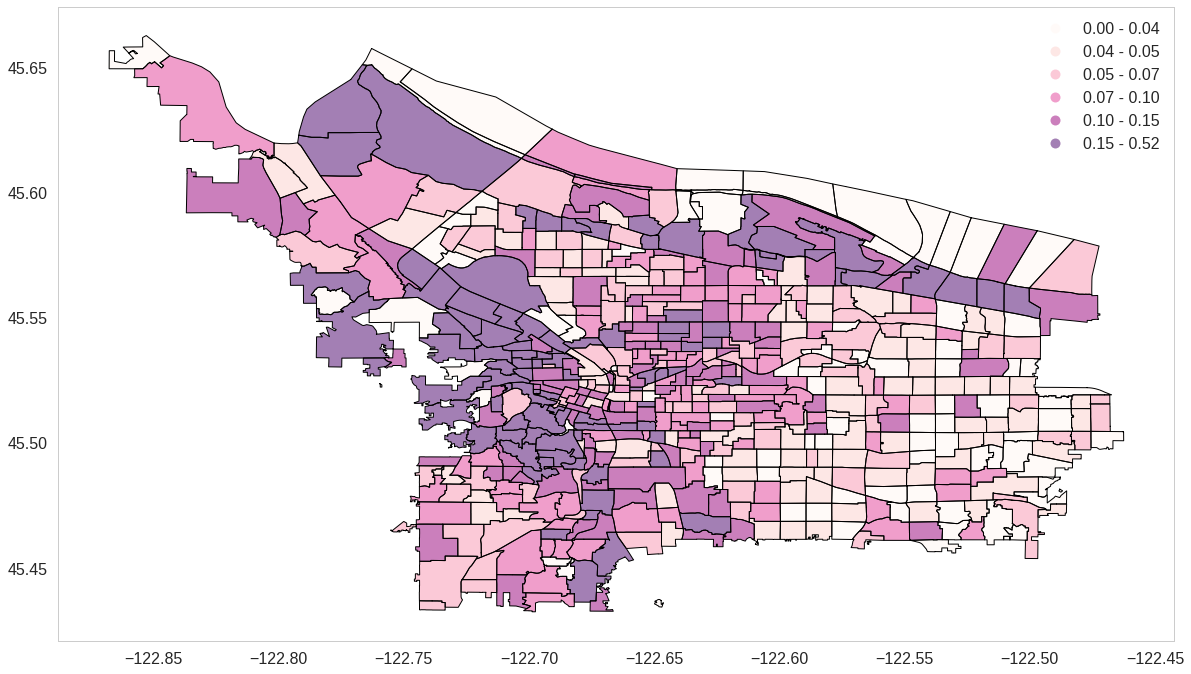

In [42]:
Fireblock_Summaries_df.plot(figsize=(20,20), column='fa_total_ratio', cmap='RdPu', scheme='QUANTILES', k=6, legend=True)

### Commerical Alarm False Call to Total Incident Ratio by Fire Management Area

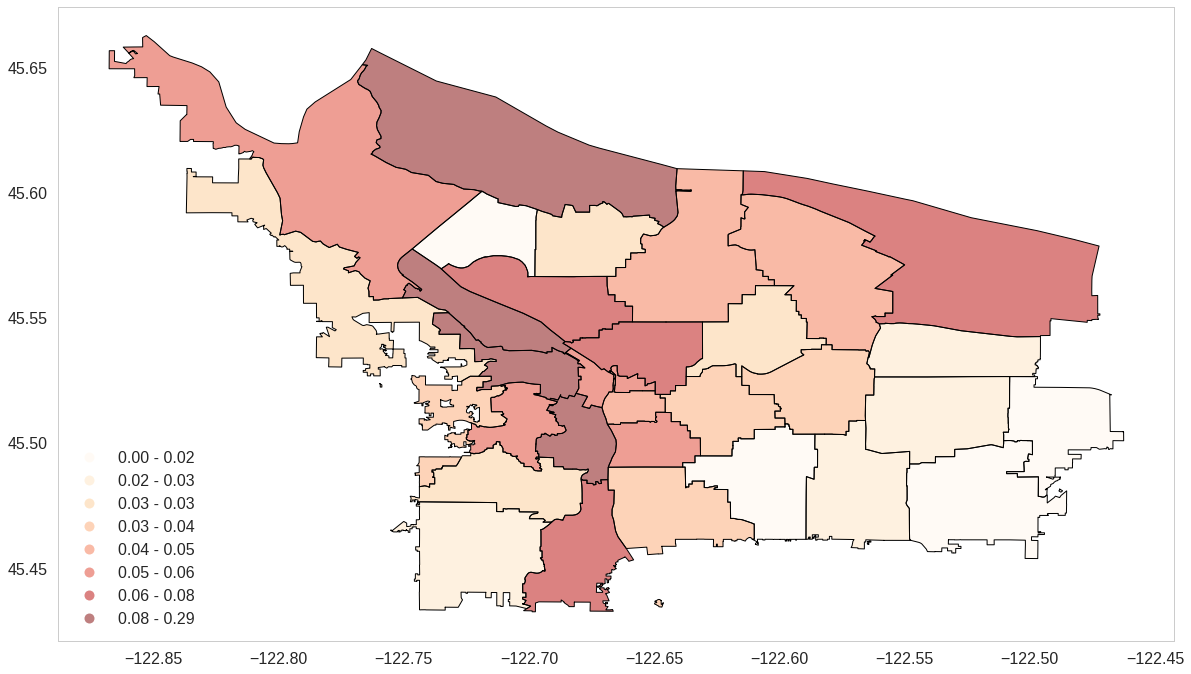

In [43]:
FMA_Summaries_df.plot(figsize=(20,20), column='alarmcomm_fa_ratio', cmap='OrRd', scheme='QUANTILES', k=8, legend=True)

### Commerical Alarm False Call to Total Incident Ratio by Block Group

High ratio of commerical fire alarms in industrial/commercial areas. 

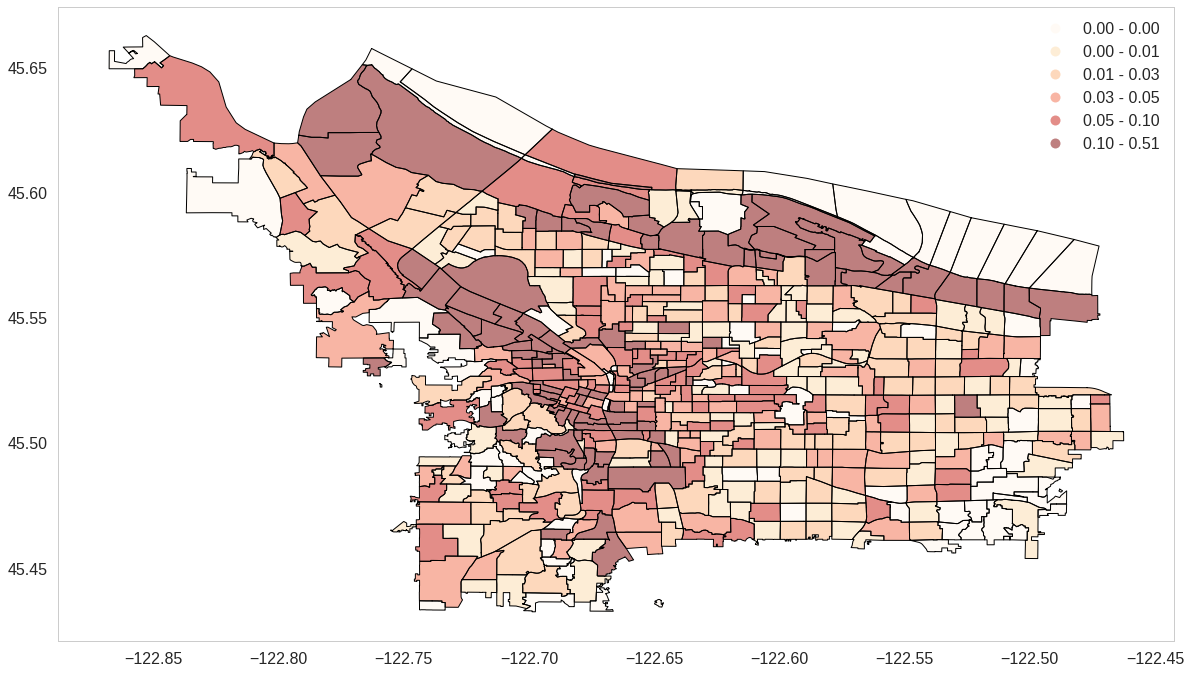

In [45]:
Fireblock_Summaries_df.plot(figsize=(20,20), column='alarmcomm_fa_ratio', cmap='OrRd', scheme='QUANTILES', k=6, legend=True)

### Residential Alarm False Calls to Total Incident Ratio by Fire Management Area

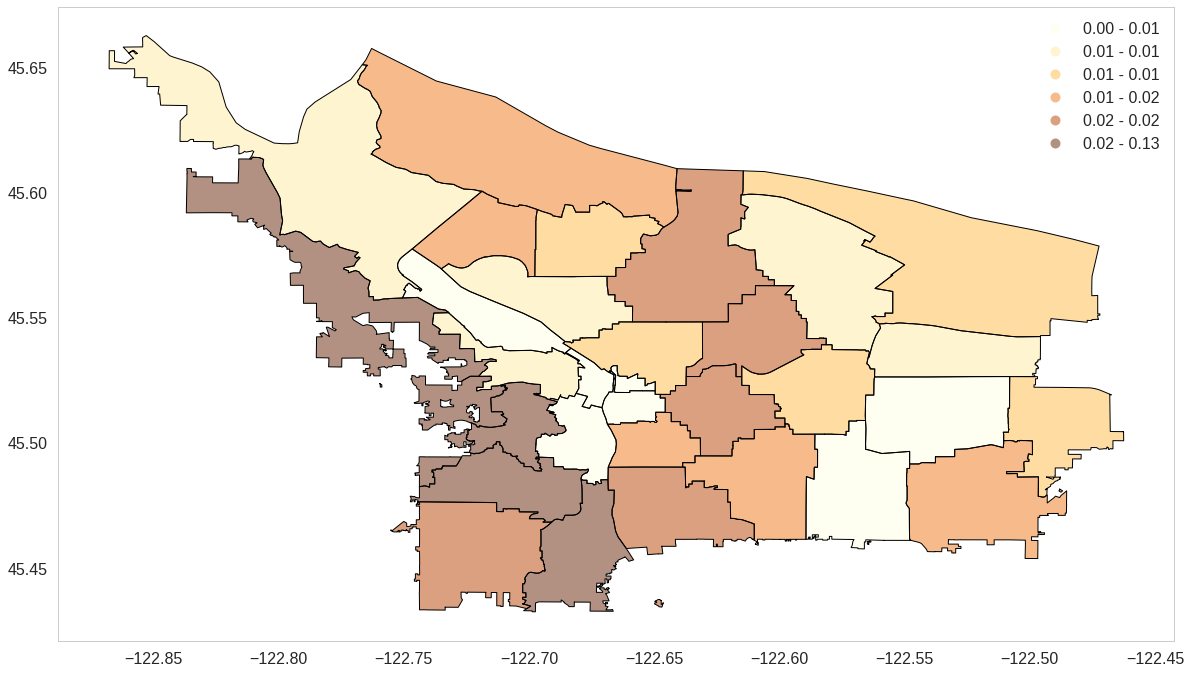

In [46]:
FMA_Summaries_df.plot(figsize=(20,20), column='alarmres_fa_ratio', cmap='YlOrBr', scheme='QUANTILES', k=6, legend=True)

### Residential Alarm False Calls to Total Incident Ratio by Block Groups

High frequency of calls in west hills, ie wealthy neighborhoods (possibly with high frequency of home alarms). 

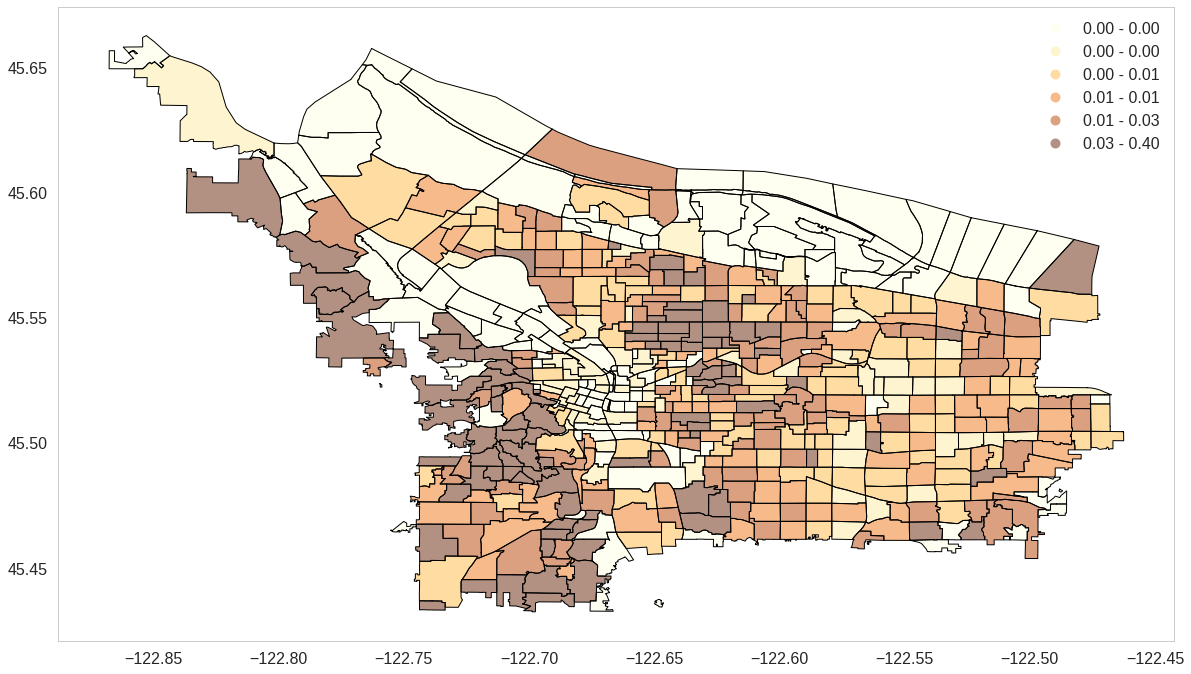

In [48]:
Fireblock_Summaries_df.plot(figsize=(20,20), column='alarmres_fa_ratio', cmap='YlOrBr', scheme='QUANTILES', k=6, legend=True)

Next Steps:

* Count avg responders per incident
* Timeseries - trendin . 
* Probability of a call being false - given fire block, time of day, description - what's the probabilty of a false call? 